In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#import warnings
#warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("whitegrid")
import datetime
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import random
import string
import datetime as dt 
from datetime import datetime

from scipy import stats
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
#import jenkspy

#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules
#from mlxtend.preprocessing import TransactionEncoder
#from mlxtend.frequent_patterns import fpgrowth

In [5]:
data_rfm = pd.read_csv("cleaned_data.csv")
data_rfm = data_rfm.iloc[: , 1:]
data_rfm.head()

,order_date,customer_id,order_id,product_group,detailed_category,product_id,product_name,sku,qty_ordered,gross_revenue,net_revenue
0,2022-04-10,F125YX,7269150,Emma Others,Beds,12164,Emma Revor BSB 180x200 - BG Bedbase P2,EBDRV180200C32,1,282.85,212.66
1,2022-04-29,RY8A7X,7426895,Emma Mattress Protector V3,Accessories,7458,Emma Mattress Protector V3 200x200,ESSES200200AAC,1,96.75,68.13
2,2022-05-22,ZPUQOH,7588817,Emma Others,Accessories,8293,Emma Foam Pillow 80x40 V2,EPWFP080040AAB,1,54.40,41.01
3,2022-01-02,TSK3PM,6401748,Emma ONE Mattress medium,Basic Mattress,3138,Emma One Medium 090x200,EMAON090200CAC,2,362.02,304.21
4,2022-04-10,OC9N75,7262778,Emma Others,Basic Mattress,4570,Emma Dynamic Mattress-180 X 200 cm,EMADY180200AAA,1,441.75,332.12


### 1.0 Create Columns: Recency, Frequency, Monetary

In [6]:
# Create Column: Recency
data_rfm['order_date'] = pd.to_datetime(data_rfm['order_date'], format='%Y-%m-%d')
data_rfm['order_date'].head()

0   2022-04-10
1   2022-04-29
2   2022-05-22
3   2022-01-02
4   2022-04-10
Name: order_date, dtype: datetime64[ns]

In [7]:
#Define cut-off date - 01/08/2022
cut_off_date = pd.to_datetime(20220801, format='%Y%m%d')

In [8]:
data_rfm['days_recency'] = (cut_off_date - data_rfm['order_date']).dt.days
data_rfm['days_recency'].head()

0    113
1     94
2     71
3    211
4    113
Name: days_recency, dtype: int64

In [9]:
data_rfm.head()

,order_date,customer_id,order_id,product_group,detailed_category,product_id,product_name,sku,qty_ordered,gross_revenue,net_revenue,days_recency
0,2022-04-10,F125YX,7269150,Emma Others,Beds,12164,Emma Revor BSB 180x200 - BG Bedbase P2,EBDRV180200C32,1,282.85,212.66,113
1,2022-04-29,RY8A7X,7426895,Emma Mattress Protector V3,Accessories,7458,Emma Mattress Protector V3 200x200,ESSES200200AAC,1,96.75,68.13,94
2,2022-05-22,ZPUQOH,7588817,Emma Others,Accessories,8293,Emma Foam Pillow 80x40 V2,EPWFP080040AAB,1,54.40,41.01,71
3,2022-01-02,TSK3PM,6401748,Emma ONE Mattress medium,Basic Mattress,3138,Emma One Medium 090x200,EMAON090200CAC,2,362.02,304.21,211
4,2022-04-10,OC9N75,7262778,Emma Others,Basic Mattress,4570,Emma Dynamic Mattress-180 X 200 cm,EMADY180200AAA,1,441.75,332.12,113


In [10]:
data_recency = data_rfm.groupby('customer_id')['days_recency'].min().reset_index().rename(columns={"days_recency":"recency"})
data_recency.head()

,customer_id,recency
0,0002YJ,395
1,000986,483
2,000CMS,536
3,000H95,628
4,000IS0,723


In [11]:
# Create Column: Frequency
data_frequency = data_rfm.groupby('customer_id')['order_id'].count().reset_index().rename(columns={"order_id":"frequency"})
data_frequency.head()

,customer_id,frequency
0,0002YJ,1
1,000986,1
2,000CMS,1
3,000H95,1
4,000IS0,2


In [12]:
#Create Column:  Monetary
data_monetary=data_rfm.groupby('customer_id')['gross_revenue'].sum().reset_index().rename(columns={"gross_revenue":"monetary"})
data_monetary.head()

,customer_id,monetary
0,0002YJ,298.32
1,000986,155.22
2,000CMS,166.32
3,000H95,57.60
4,000IS0,358.20


In [13]:
# Merge the 3 dataframes created for recency, frequency and monetary
RF=pd.merge(data_recency,data_frequency,on='customer_id')
RFM=pd.merge(RF,data_monetary,on='customer_id')
RFM.head()

,customer_id,recency,frequency,monetary
0,0002YJ,395,1,298.32
1,000986,483,1,155.22
2,000CMS,536,1,166.32
3,000H95,628,1,57.60
4,000IS0,723,2,358.20


In [14]:
## verify results
RFM.describe()

,recency,frequency,monetary
count,776518.000000,776518.000000,776518.000000
mean,396.923098,1.530995,360.231468
std,248.017362,1.101341,261.814979
min,1.000000,1.000000,2.200000
25%,181.000000,1.000000,192.600000
50%,370.000000,1.000000,319.440000
75%,610.000000,2.000000,433.467500
max,943.000000,91.000000,29417.700000


### 2.0 RFM framework K-means Clustering

In [15]:
rfm_kmeans = RFM.copy()

<Figure size 1152x1008 with 0 Axes>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='frequency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monetary', ylabel='Density'>

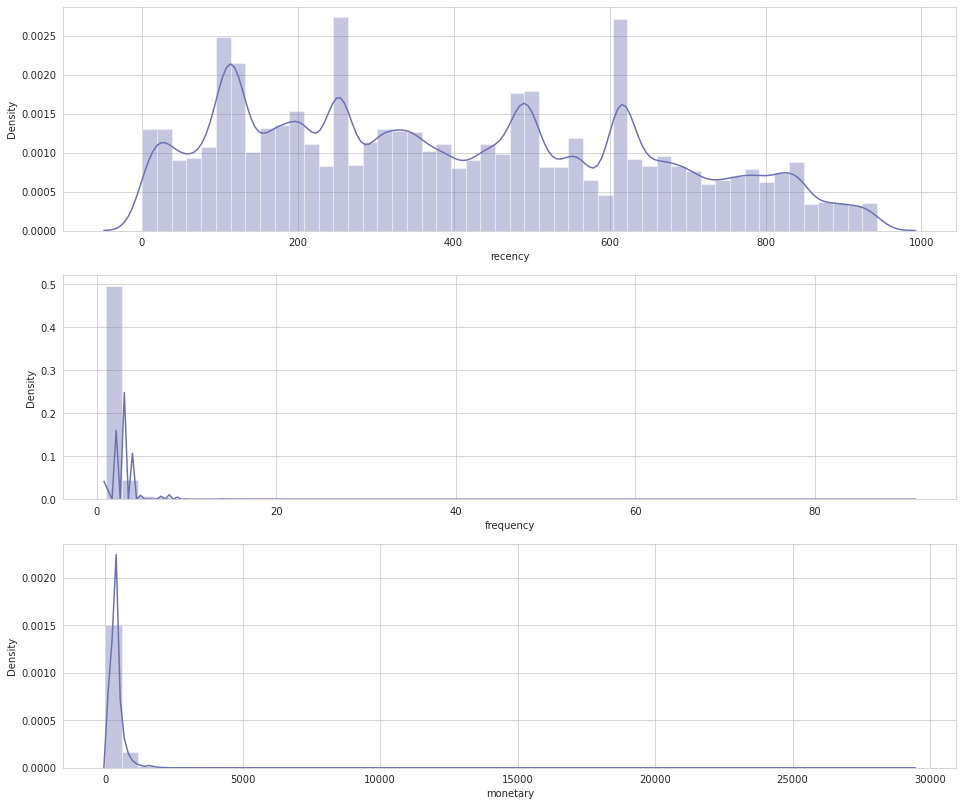

In [16]:
#check current skewness
plt.figure(figsize=(16,14))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_kmeans['recency'],color="#6c71b1")
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_kmeans['frequency'],color="#6c71b1")
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_kmeans['monetary'],color="#6c71b1")

# Show the plot
plt.show()

<Figure size 1152x1008 with 0 Axes>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='frequency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monetary', ylabel='Density'>

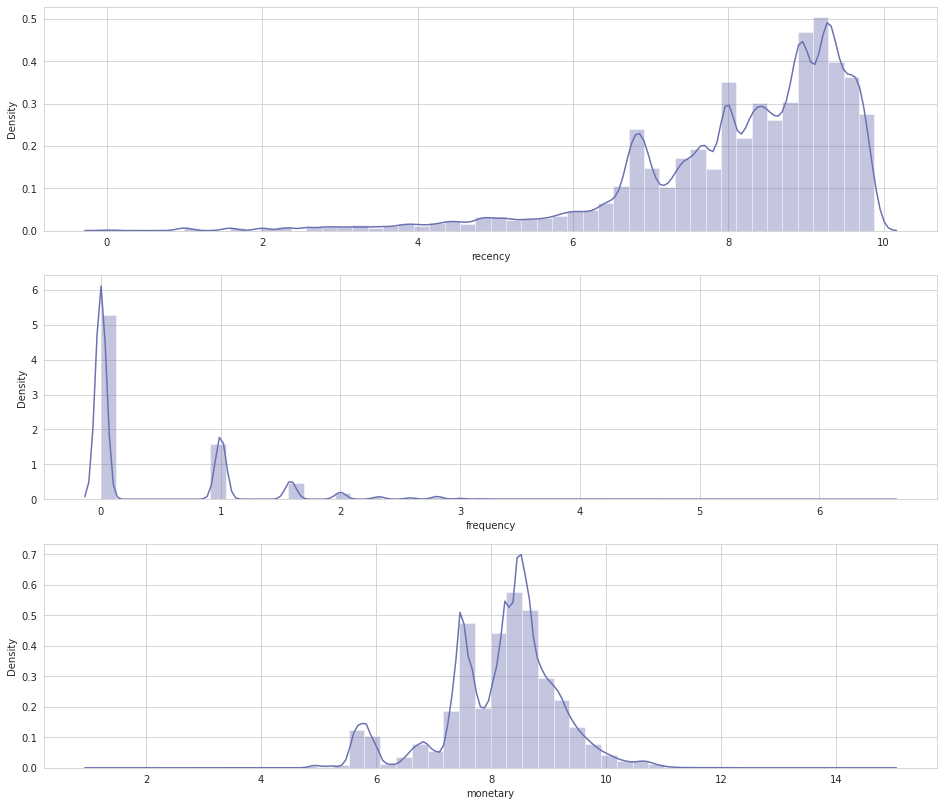

In [17]:
#normalisation 
#adapted from https://towardsdatascience.com/rfmt-segmentation-using-k-means-clustering-76bc5040ead5

# Apply Log Transformation
rfm_kmeans['monetary'] = rfm_kmeans['monetary'] + 0.0000000001
recency_log = np.log2(rfm_kmeans['recency'])
frequency_log = np.log2(rfm_kmeans['frequency'])
monetary_log = np.log2(rfm_kmeans['monetary'])

# Plot RFM distributions
plt.figure(figsize=(16,14))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(recency_log, color="#6c71b1")
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(frequency_log, color="#6c71b1")
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(monetary_log, color="#6c71b1")

# Show the plot
plt.show()

In [18]:
#scaling
#adapted from https://towardsdatascience.com/rfmt-segmentation-using-k-means-clustering-76bc5040ead5
data_for_clustering_scaled = rfm_kmeans.iloc[:, 1:4]
scaler = StandardScaler()
scaler.fit(data_for_clustering_scaled)
data_for_clustering_scaled = scaler.transform(data_for_clustering_scaled)

data_for_clustering_scaled = pd.DataFrame(data_for_clustering_scaled, columns=["recency","frequency","monetary"])
data_for_clustering_scaled.head(10)

StandardScaler()

,recency,frequency,monetary
0,-0.007754,-0.482135,-0.236470
1,0.347060,-0.482135,-0.783040
2,0.560755,-0.482135,-0.740644
3,0.931697,-0.482135,-1.155899
4,1.314735,0.425850,-0.007759
5,0.121269,-0.482135,-0.566704
6,-1.572162,-0.482135,-0.290211
7,0.387380,0.425850,0.219119
8,-1.560066,-0.482135,-0.859697
9,0.665587,-0.482135,-0.007759


In [19]:
rfm_kmeans.head()

,customer_id,recency,frequency,monetary
0,0002YJ,395,1,298.32
1,000986,483,1,155.22
2,000CMS,536,1,166.32
3,000H95,628,1,57.60
4,000IS0,723,2,358.20


KMeans(n_clusters=1, random_state=1)

KMeans(n_clusters=2, random_state=1)

KMeans(n_clusters=3, random_state=1)

KMeans(n_clusters=4, random_state=1)

KMeans(n_clusters=5, random_state=1)

KMeans(n_clusters=6, random_state=1)

KMeans(n_clusters=7, random_state=1)

KMeans(random_state=1)

KMeans(n_clusters=9, random_state=1)

KMeans(n_clusters=10, random_state=1)

KMeans(n_clusters=11, random_state=1)

KMeans(n_clusters=12, random_state=1)

KMeans(n_clusters=13, random_state=1)

KMeans(n_clusters=14, random_state=1)

Text(0.5, 0, 'Number of clusters, k')

Text(0, 0.5, 'Inertia')

([<matplotlib.axis.XTick at 0x7f274c1d4a00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None]

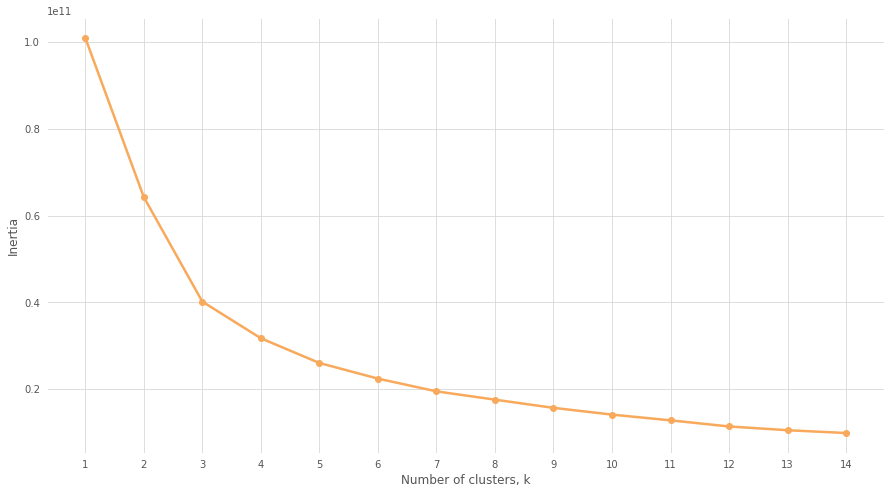

In [28]:
#Get the Best KMeans: Inertia Method
ks = range(1,15)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_kmeans.iloc[:,1:4])
    inertias.append(kc.inertia_)
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o', color = "#f8a95c", linewidth= 2.5)
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
ax.set(facecolor = "white")
plt.savefig("inertia.png",bbox_inches='tight')
plt.show()

In [21]:
#Get the Best KMeans: Scaled Inertia Method
#adapted from https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c
def kMeansRes(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

In [22]:
#data_for_clustering = rfm_kmeans.iloc[:, 1:4]
scaled_data = np.asarray(data_for_clustering_scaled).astype(float)

# choose k range
k_range=range(1,15)

# compute adjusted intertia
best_k, results = chooseBestKforKMeans(scaled_data, k_range)

Text(0.5, 1.0, 'Adjusted Inertia for each K')

Text(0.5, 0, 'K')

Text(0, 0.5, 'Adjusted Inertia')

([<matplotlib.axis.XTick at 0x7f274c259be0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None]

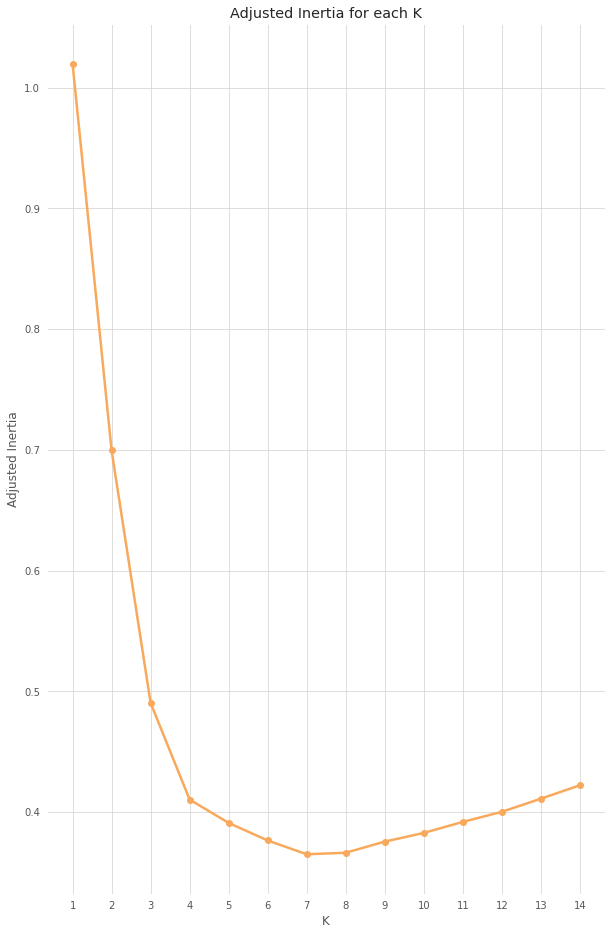

In [27]:
# plot the results
f, ax = plt.subplots(figsize=(10, 16))
plt.plot(results,'-o', color = "#f8a95c", linewidth= 2.5)
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(1,15,1))
plt.style.use('ggplot')
plt.rcParams['grid.color'] = '#d7d6d2'
ax.set(facecolor = "white")
plt.savefig("scaled_inertia.png",bbox_inches='tight')
plt.show()

In [21]:
kc = KMeans(n_clusters= 7, random_state=88)
kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_k7 = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k7.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

KMeans(n_clusters=7, random_state=88)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.9911   -0.3919  -0.5851  180873
1         -0.8472    0.1214   0.5714  118428
2          1.3322   -0.4500  -0.3447  156074
3          0.9217    0.6678   0.3867   84108
4         -0.8725    5.1372   4.3899   13025
5         -0.5749    1.9342   1.7199   41903
6          0.1626   -0.4249  -0.3834  182107

In [22]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_kmeans.index,columns=rfm_kmeans.columns)

rfm_norm["customer_id"] = rfm_kmeans['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,6,recency,-0.007754
1,000986,6,recency,0.347060
2,000CMS,6,recency,0.560755
3,000H95,2,recency,0.931697
4,000IS0,3,recency,1.314735


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

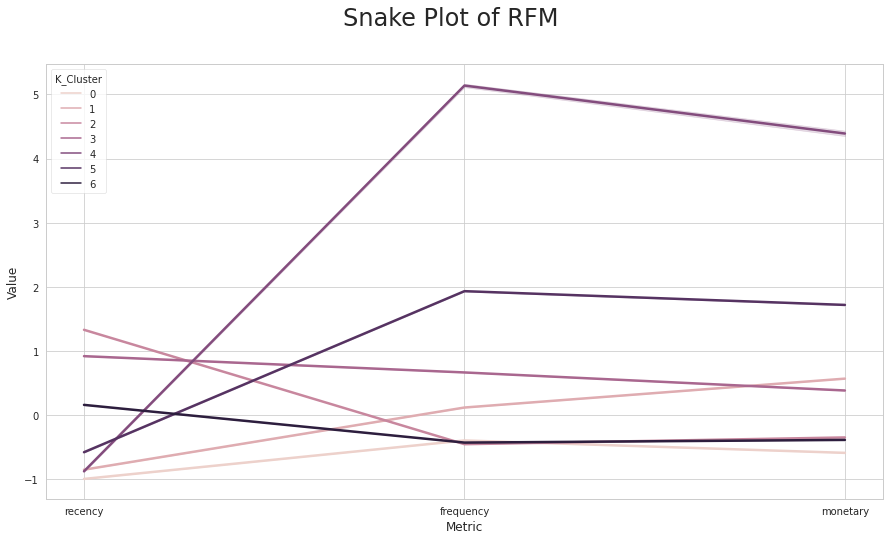

In [23]:
# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt, linewidth=2.5)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

### 2.1 Cluster Initialisation

#### 2.1.1 Initialisation method: Kmeans++

In [63]:
kc = KMeans(n_clusters= 7, init = 'k-means++', random_state=88)
kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_k7_plusplus = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k7_plusplus.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

KMeans(n_clusters=7, random_state=88)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.9911   -0.3919  -0.5851  180873
1         -0.8472    0.1214   0.5714  118428
2          1.3322   -0.4500  -0.3447  156074
3          0.9217    0.6678   0.3867   84108
4         -0.8725    5.1372   4.3899   13025
5         -0.5749    1.9342   1.7199   41903
6          0.1626   -0.4249  -0.3834  182107

In [64]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_kmeans.index,columns=rfm_kmeans.columns)

rfm_norm["customer_id"] = rfm_kmeans['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt_plusplus = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt_plusplus.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,6,recency,-0.007754
1,000986,6,recency,0.347060
2,000CMS,6,recency,0.560755
3,000H95,2,recency,0.931697
4,000IS0,3,recency,1.314735


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

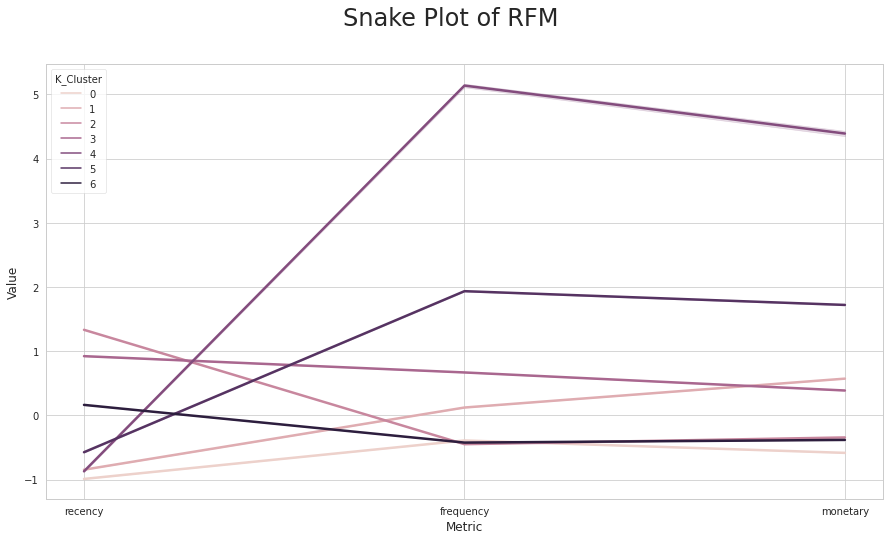

In [65]:
# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt_plusplus, linewidth=2.5)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Relative importance of attributes')

<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='K_Cluster'>

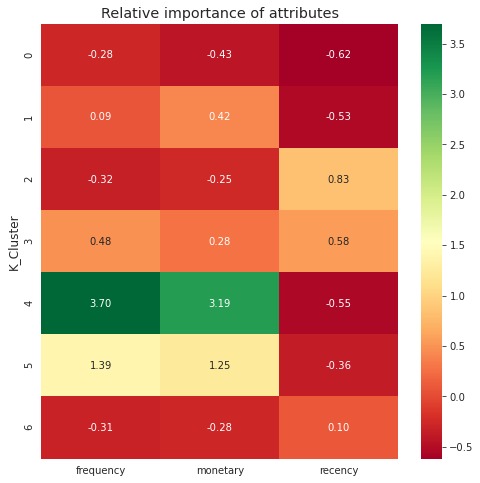

In [66]:
rel_imp_plusplus = pd.merge(rfm_kmeans, rfm_melt_plusplus[["customer_id","K_Cluster"]], on= "customer_id", how = "left")
rel_imp_plusplus.drop("customer_id", axis=1, inplace=True)

# Calculate average RFM values for each cluster
cluster_avg = rel_imp_plusplus.groupby(['K_Cluster']).mean()
# Calculate average RFM values for the total customer population
population_avg = rel_imp_plusplus.mean()
# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg-1
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 8))
# Add the plot title
plt.title('Relative importance of attributes')
# Plot the heatmap
sns.heatmap(data=relative_imp.iloc[:,1:4], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

#### 2.1.2 Initialisation method: Random

In [28]:
# adapted from https://medium.com/analytics-vidhya/comparison-of-initialization-strategies-for-k-means-d5ddd8b0350e
kc = KMeans(n_clusters= 7, init = 'random', random_state=88)
kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_k7_random = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k7_random.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

KMeans(init='random', n_clusters=7, random_state=88)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.8468    0.1194   0.5710  118350
1          1.3320   -0.4497  -0.3444  156211
2          0.9202    0.6681   0.3869   84194
3          0.1614   -0.4252  -0.3848  182224
4         -0.5768    1.9316   1.7179   41994
5         -0.8722    5.1365   4.3888   13033
6         -0.9924   -0.3917  -0.5848  180512

In [29]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_kmeans.index,columns=rfm_kmeans.columns)

rfm_norm["customer_id"] = rfm_kmeans['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt_random = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt_random.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,3,recency,-0.007754
1,000986,3,recency,0.347060
2,000CMS,3,recency,0.560755
3,000H95,1,recency,0.931697
4,000IS0,2,recency,1.314735


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

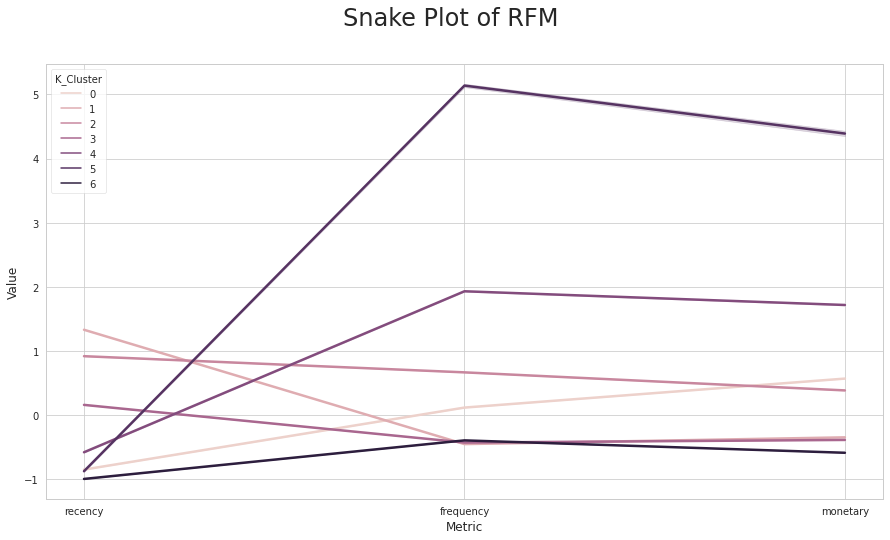

In [30]:
# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt_random, linewidth=2.5)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Relative importance of attributes')

<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='K_Cluster'>

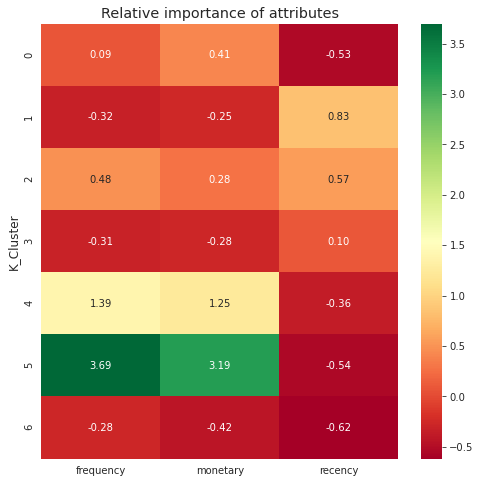

In [62]:
rel_imp_random = pd.merge(rfm_kmeans, rfm_melt_random[["customer_id","K_Cluster"]], on= "customer_id", how = "left")
rel_imp_random.drop("customer_id", axis=1, inplace=True)

# Calculate average RFM values for each cluster
cluster_avg = rel_imp_random.groupby(['K_Cluster']).mean()
# Calculate average RFM values for the total customer population
population_avg = rel_imp_random.mean()
# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg-1
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 8))
# Add the plot title
plt.title('Relative importance of attributes')
# Plot the heatmap
sns.heatmap(data=relative_imp.iloc[:,1:4], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

#### 2.1.3 Initialisation method: random partition

In [43]:
# adapted from https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html
def random_partition(X, k):
    '''Assign each point randomly to a cluster. Then calculate the
       Average data in each cluster to get the centers'''
    indices = np.random.choice(range(0, k), replace = True, size = X.shape[0])
    mean = []
    for count in range(k):
        mean.append(X[indices == count].mean(axis=0))
        
    return np.concatenate([val[ None, :] for val in mean], axis = 0)

In [44]:
rand_partition_init = random_partition(data_for_clustering_scaled.to_numpy(), 7)

In [45]:
kc = KMeans(n_clusters= 7, init = rand_partition_init, random_state=0)
kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_k7_randpartition = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k7_randpartition.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


KMeans(init=array([[-0.00225168, -0.00090644,  0.00405972],
       [-0.00280109, -0.00124458, -0.0026853 ],
       [ 0.0042777 , -0.0034336 , -0.00265934],
       [ 0.00423332, -0.00127802, -0.0002638 ],
       [-0.00156141,  0.00334511, -0.00139051],
       [ 0.00045609,  0.00075075,  0.00127469],
       [-0.00234778,  0.00276505,  0.00167356]]),
       n_clusters=7, random_state=0)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.8491    0.0677   0.5371  123822
1         -0.9912   -0.3896  -0.6126  174733
2          0.1682   -0.4256  -0.3862  180678
3          1.3343   -0.4450  -0.3439  156607
4          0.9094    0.6715   0.3957   83930
5         -0.5946    1.8938   1.6844   43607
6         -0.8686    5.1237   4.3775   13141

In [46]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_kmeans.index,columns=rfm_kmeans.columns)

rfm_norm["customer_id"] = rfm_kmeans['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt_randpartition = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt_randpartition.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,2,recency,-0.007754
1,000986,2,recency,0.347060
2,000CMS,2,recency,0.560755
3,000H95,3,recency,0.931697
4,000IS0,4,recency,1.314735


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

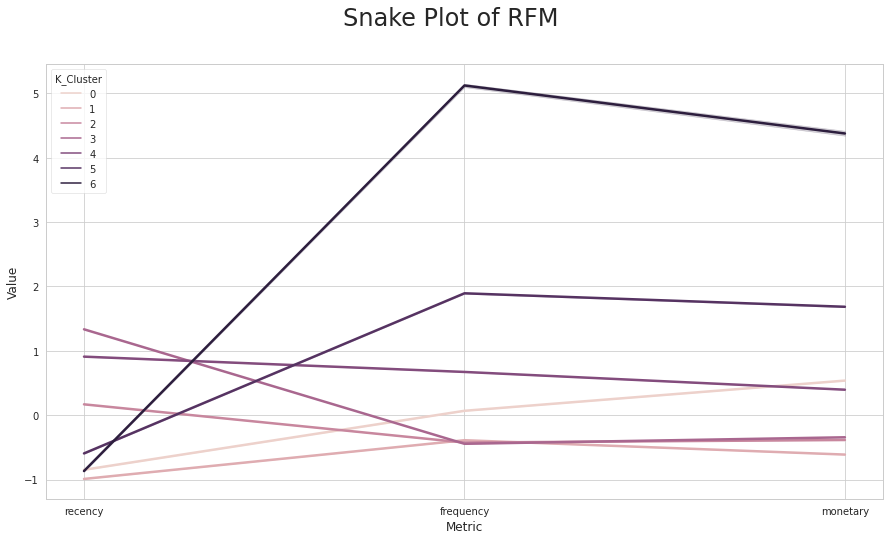

In [47]:
# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt_randpartition, linewidth=2.5)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Relative importance of attributes')

<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='K_Cluster'>

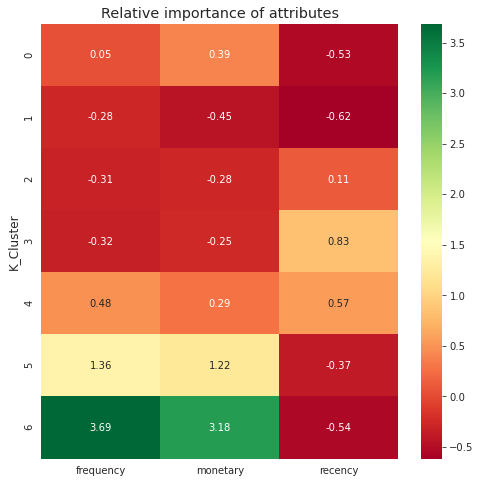

In [61]:
rel_imp_randpartition = pd.merge(rfm_kmeans, rfm_melt_randpartition[["customer_id","K_Cluster"]], on= "customer_id", how = "left")
rel_imp_randpartition.drop("customer_id", axis=1, inplace=True)

# Calculate average RFM values for each cluster
cluster_avg = rel_imp_randpartition.groupby(['K_Cluster']).mean()
# Calculate average RFM values for the total customer population
population_avg = rel_imp_randpartition.mean()
# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg-1
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 8))
# Add the plot title
plt.title('Relative importance of attributes')
# Plot the heatmap
sns.heatmap(data=relative_imp.iloc[:,1:4], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

#### 2.1.4 Initialisation method: naive sharding

In [80]:
# adapted from https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html
def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    def _get_mean(sums, step):
        """Vectorizable ufunc for getting means of summed shard columns."""
        return sums/step

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.zeros((k, n))

    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    step = floor(m/k)
    vfunc = np.vectorize(_get_mean)

    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

In [81]:
naive_sharding_init = naive_sharding(data_for_clustering_scaled.to_numpy(), 7)

In [82]:
kc = KMeans(n_clusters= 7, init = naive_sharding_init, random_state=88)
kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_k7_naivesharding = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k7_naivesharding.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


KMeans(init=array([[-1.3521602 , -0.48213515, -1.02596466],
       [-0.97646876, -0.48213515, -0.67800158],
       [-0.56000528, -0.48213515, -0.40192025],
       [-0.09301007, -0.48213515, -0.1329631 ],
       [ 0.41493125, -0.31494567,  0.06952533],
       [ 0.93112113,  0.42584959,  0.4163087 ],
       [ 1.63559194,  1.81763669,  1.75301556]]),
       n_clusters=7, random_state=88)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.9915   -0.3896  -0.6135  174414
1         -0.8481    0.0634   0.5351  123819
2         -0.5939    1.8829   1.6733   44133
3          0.1678   -0.4255  -0.3865  180649
4          1.3338   -0.4482  -0.3442  156094
5          0.9154    0.6684   0.3892   84216
6         -0.8681    5.1177   4.3716   13193

In [83]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_kmeans.index,columns=rfm_kmeans.columns)

rfm_norm["customer_id"] = rfm_kmeans['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt_naivesharding = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt_naivesharding.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,3,recency,-0.007754
1,000986,3,recency,0.347060
2,000CMS,3,recency,0.560755
3,000H95,4,recency,0.931697
4,000IS0,5,recency,1.314735


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

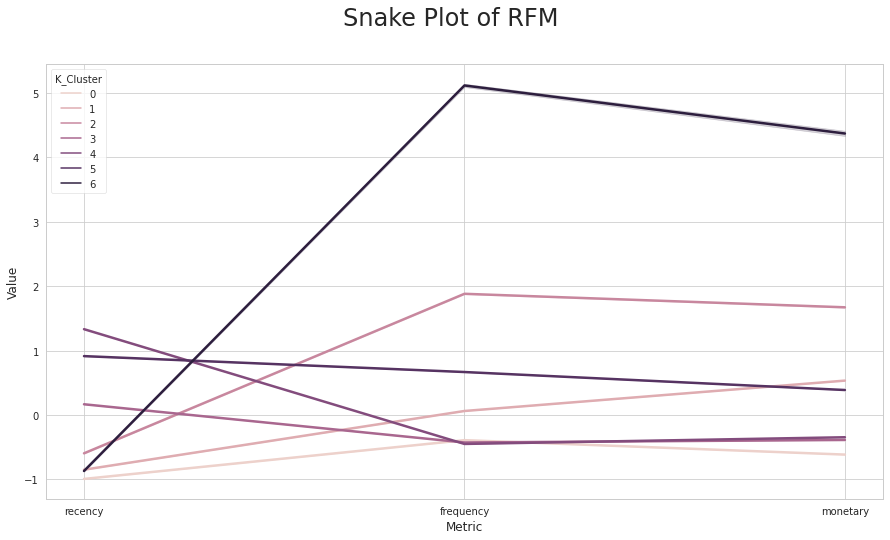

In [84]:
# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt_naivesharding, linewidth=2.5)
plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Relative importance of attributes')

<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='K_Cluster'>

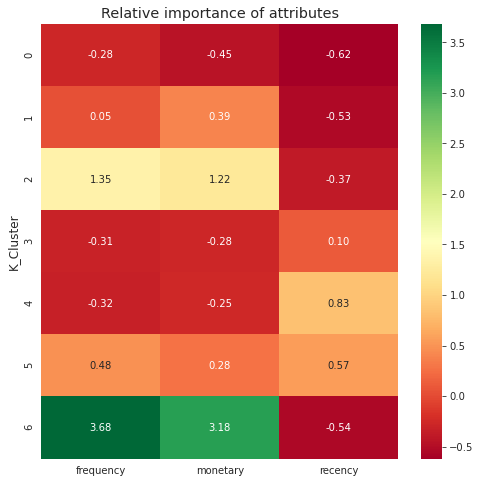

In [85]:
rel_imp_naivesharding = pd.merge(rfm_kmeans, rfm_melt_naivesharding[["customer_id","K_Cluster"]], on= "customer_id", how = "left")
rel_imp_naivesharding.drop("customer_id", axis=1, inplace=True)

# Calculate average RFM values for each cluster
cluster_avg = rel_imp_naivesharding.groupby(['K_Cluster']).mean()
# Calculate average RFM values for the total customer population
population_avg = rel_imp_naivesharding.mean()
# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg-1
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 8))
# Add the plot title
plt.title('Relative importance of attributes')
# Plot the heatmap
sns.heatmap(data=relative_imp.iloc[:,1:4], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

### 2.2 Evaluation

In [88]:
rfm_k7_naivesharding.head()

,recency,frequency,monetary,K_Cluster
0,-0.007754,-0.482135,-0.236470,3
1,0.347060,-0.482135,-0.783040,3
2,0.560755,-0.482135,-0.740644,3
3,0.931697,-0.482135,-1.155899,4
4,1.314735,0.425850,-0.007759,5


In [90]:
from sklearn.metrics import silhouette_score
#Naive Sharding
silhouette_score(rfm_k7_naivesharding, rfm_k7_naivesharding["K_Cluster"], metric="euclidean", random_state=88)

0.5129482226518476

In [91]:
#Random Partition
silhouette_score(rfm_k7_randpartition, rfm_k7_randpartition["K_Cluster"], metric="euclidean", random_state=88)

0.49058464139764574

In [94]:
#Random
silhouette_score(rfm_k7_random, rfm_k7_random["K_Cluster"], metric="euclidean", random_state=88)

0.6190644249852612

In [95]:
#Kmeans++
silhouette_score(rfm_k7_plusplus, rfm_k7_plusplus["K_Cluster"], metric="euclidean", random_state=88)

0.5836036702202305

#### 2.2.1 Selecting the best k-means clustering result

from the evaluation of the silhouette score, the random initialisation method results in the best silhouette score. Hence, we will put this result forward for the MBA

In [131]:
rfm_melt_random.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,3,recency,-0.007754
1,000986,3,recency,0.347060
2,000CMS,3,recency,0.560755
3,000H95,1,recency,0.931697
4,000IS0,2,recency,1.314735


In [132]:
rfm_melt_random.to_csv("rfm_melt_random.csv", index = False)

In [166]:
from sklearn.manifold import TSNE
def kmeans(data_for_clustering_scaled, clusters_number, rfm_rfm):
    kmeans = KMeans(n_clusters = 7, init='random', random_state = 88)
    kmeans.fit(data_for_clustering_scaled) # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = rfm_rfm.assign(Cluster = cluster_labels)
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(7))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    return df_new

<Figure size 720x720 with 0 Axes>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


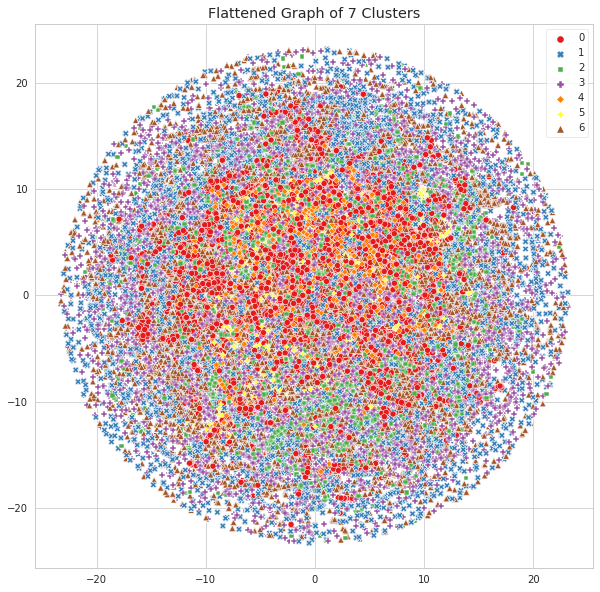

In [168]:
plt.figure(figsize=(10, 10))
df_rfm_random = kmeans(data_for_clustering_scaled, 7, rfm_rfm)
plt.show()

In [172]:
rfm_kmeans.to_csv("rfm_kmeans.csv", index=False)

**End of Code**

## Appendix: Considered methods - RFM Score based K-means Clustering

### 1.0 Quantile-based RFM Score
RFM_Score = `r_quartile` + `f_quartile` + `m_quartile`


source: Wei et al 2010

In [14]:
quantiles = RFM.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
segmented_rfm = RFM.copy()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles))
segmented_rfm.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,0002YJ,395,1,298.32,3,4,3
1,000986,483,1,155.22,3,4,4
2,000CMS,536,1,166.32,3,4,4
3,000H95,628,1,57.60,4,4,4
4,000IS0,723,2,358.20,4,2,2


In [18]:
segmented_rfm['RFM_Segment'] = segmented_rfm.r_quartile.map(str)+ segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment
0,0002YJ,395,1,298.32,3,4,3,343
1,000986,483,1,155.22,3,4,4,344
2,000CMS,536,1,166.32,3,4,4,344
3,000H95,628,1,57.60,4,4,4,444
4,000IS0,723,2,358.20,4,2,2,422


In [19]:
segmented_rfm['RFM_Score'] = segmented_rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
segmented_rfm

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
0,0002YJ,395,1,298.32,3,4,3,343,10
1,000986,483,1,155.22,3,4,4,344,11
2,000CMS,536,1,166.32,3,4,4,344,11
3,000H95,628,1,57.60,4,4,4,444,12
4,000IS0,723,2,358.20,4,2,2,422,8
...,...,...,...,...,...,...,...,...,...
776513,ZZZKP6,283,1,64.00,2,4,4,244,10
776514,ZZZLL5,917,1,389.35,4,4,2,442,10
776515,ZZZPW3,235,1,51.68,2,4,4,244,10
776516,ZZZR4P,248,2,275.45,2,2,3,223,7


### 1.1 Evaluate Quantile Assignment & RFM Score

In [20]:
len(segmented_rfm[segmented_rfm["f_quartile"] == 4])
len(segmented_rfm[segmented_rfm["f_quartile"] == 3])
len(segmented_rfm[segmented_rfm["f_quartile"] == 2])
len(segmented_rfm[segmented_rfm["f_quartile"] == 1])

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


534229

0

159302

82987

In [21]:
segmented_rfm[segmented_rfm["f_quartile"] == 4].head()
segmented_rfm[segmented_rfm["f_quartile"] == 2].head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
0,0002YJ,395,1,298.32,3,4,3,343,10
1,000986,483,1,155.22,3,4,4,344,11
2,000CMS,536,1,166.32,3,4,4,344,11
3,000H95,628,1,57.60,4,4,4,444,12
5,000KXH,427,1,211.86,3,4,3,343,10


,customer_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
4,000IS0,723,2,358.2,4,2,2,422,8
7,000NPX,493,2,417.6,3,2,2,322,7
11,000RL8,482,2,293.0,3,2,3,323,8
22,001B6K,162,2,734.6,1,2,1,121,4
28,001LE8,711,2,469.8,4,2,1,421,7


There appears to be 0 data falling into the third quartile. This is because quatile 4 comprises of transactions with frequency of 1 and quantile 2 comprises of transactions with frequency of 2. Hence, as frequency is measured in integer, with this method the third quantile possesses no data.  

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

array([ 1,  2,  7,  3,  4,  5,  8, 19,  6, 11, 12,  9, 14, 10, 15, 16, 13,
       22, 29, 18, 17, 20, 21, 37, 91, 24, 38, 30, 27])

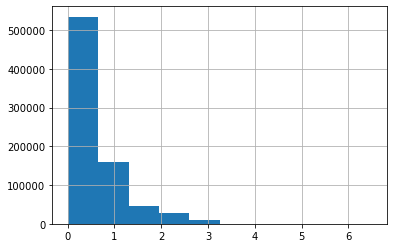

In [22]:
#0 = frequency 1, 1 = frequency 2, 2 = frequency 4
#interpretation -> 2 to the power of x
np.log2(segmented_rfm["frequency"]).hist()
segmented_rfm["frequency"].unique()

In [23]:
len(segmented_rfm[segmented_rfm["frequency"] == 1])
len(segmented_rfm[segmented_rfm["frequency"] == 2])
len(segmented_rfm[segmented_rfm["frequency"] == 3])
len(segmented_rfm[segmented_rfm["frequency"] == 4])
len(segmented_rfm[segmented_rfm["frequency"] == 8])

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


534229

159302

45968

17418

1906

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

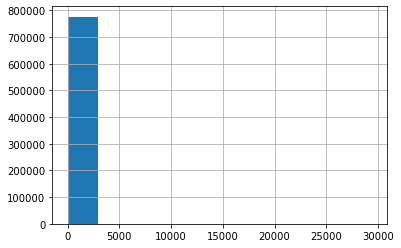

In [24]:
#check distribution of monetary
(segmented_rfm["monetary"]).hist()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

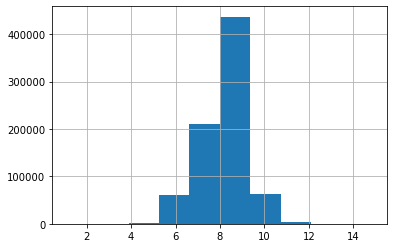

In [25]:
# check distribution of monetary, with applied log2.
np.log2(segmented_rfm["monetary"]).hist()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'RFM Segment')

Text(0, 0.5, 'Count')

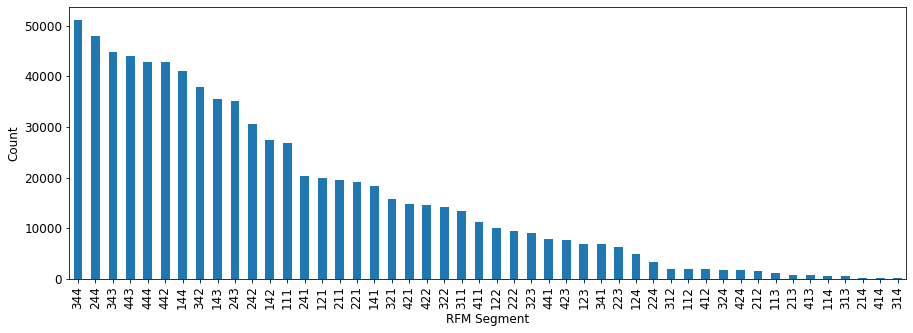

In [26]:
ax = segmented_rfm['RFM_Segment'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Segment", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

There are 48 different RFM segment, with 344 being the most populated

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'RFM Score')

Text(0, 0.5, 'Count')

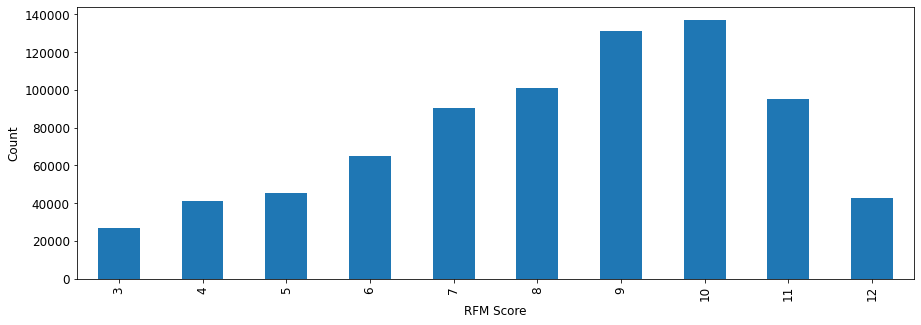

In [27]:
ax = segmented_rfm['RFM_Score'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### 2.0 Jenks Natural Breaks-Based RFM Score

#### 2.1 Jenks NB without log

In [28]:
r_breaks = jenkspy.jenks_breaks(segmented_rfm['recency'], nb_class=4)
f_breaks = jenkspy.jenks_breaks(segmented_rfm['frequency'], nb_class=4)
m_breaks = jenkspy.jenks_breaks(segmented_rfm['monetary'], nb_class=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)), 
                      columns=['J_Recency','J_Frequency', 'J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
jenks_spread

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,J_Recency,J_Frequency,J_Monetary
min,1.0,1.0,2.20
first_part,213.0,1.0,267.54
second_part,428.0,2.0,541.00
third_part,661.0,5.0,1120.95
max,943.0,91.0,29417.70


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1152x432 with 0 Axes>

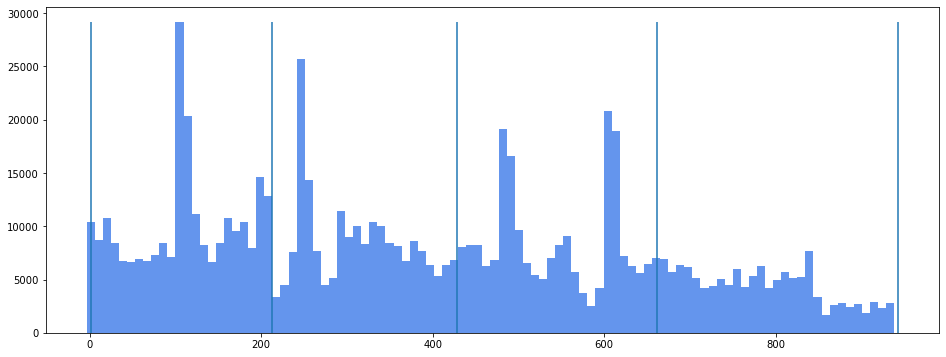

In [29]:
plt.figure(figsize = (16,6))
hist = plt.hist(segmented_rfm['recency'], bins=100, align='left', color='cornflowerblue')
for b in r_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1152x432 with 0 Axes>

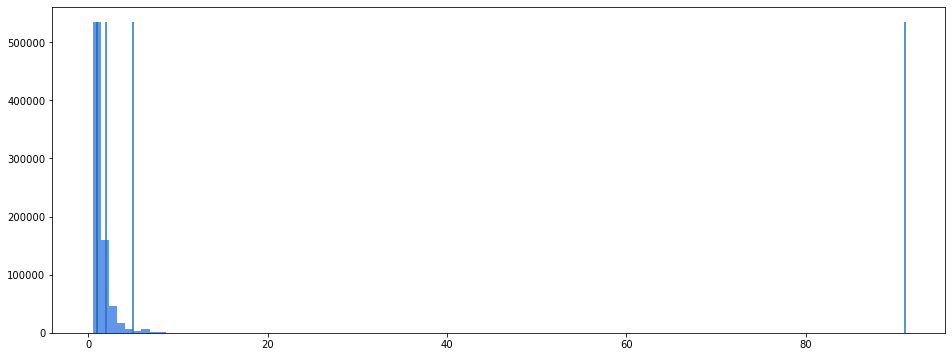

In [30]:
plt.figure(figsize = (16,6))
hist = plt.hist(segmented_rfm['frequency'], bins=100, align='left', color='cornflowerblue')
for b in f_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1152x432 with 0 Axes>

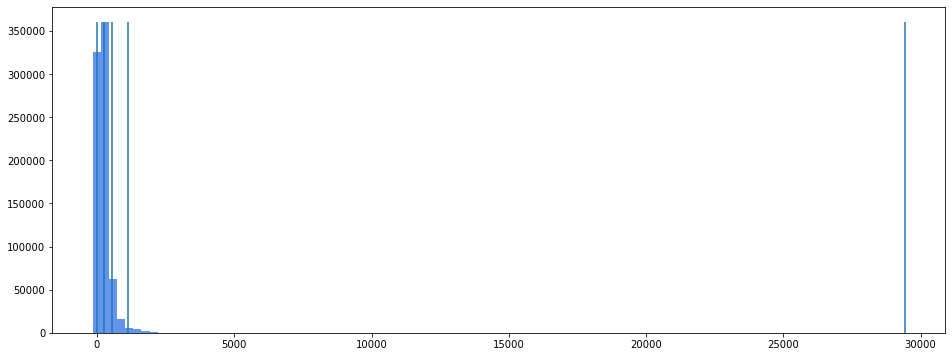

In [31]:
plt.figure(figsize = (16,6))
hist = plt.hist(segmented_rfm['monetary'], bins=100, align='left', color='cornflowerblue')
for b in m_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [32]:
rfm_jenks = RFM.copy()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
#Assign Jenks
def JenksScore_R(x):
    for i in range(0,4):
        if jenks_spread.J_Recency[i] <= x <= jenks_spread.J_Recency[i+1]:
            return (i+1)
        
def JenksScore_F(x):
    for i in range(0,4):
        if jenks_spread.J_Frequency[i] <= x <= jenks_spread.J_Frequency[i+1]:
            return (4-i)
        
def JenksScore_M(x):
    for i in range(0,4):
        if jenks_spread.J_Monetary[i] <= x <= jenks_spread.J_Monetary[i+1]:
            return (4-i)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
rfm_jenks["J_Rscore"] = rfm_jenks["recency"].apply(JenksScore_R)
rfm_jenks.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,J_Rscore
0,0002YJ,395,1,298.32,2
1,000986,483,1,155.22,3
2,000CMS,536,1,166.32,3
3,000H95,628,1,57.60,3
4,000IS0,723,2,358.20,4


In [35]:
rfm_jenks["J_Fscore"] = rfm_jenks["frequency"].apply(JenksScore_F)
rfm_jenks.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,J_Rscore,J_Fscore
0,0002YJ,395,1,298.32,2,4
1,000986,483,1,155.22,3,4
2,000CMS,536,1,166.32,3,4
3,000H95,628,1,57.60,3,4
4,000IS0,723,2,358.20,4,3


In [36]:
rfm_jenks["J_Mscore"] = rfm_jenks["monetary"].apply(JenksScore_M)
rfm_jenks.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,J_Rscore,J_Fscore,J_Mscore
0,0002YJ,395,1,298.32,2,4,3
1,000986,483,1,155.22,3,4,4
2,000CMS,536,1,166.32,3,4,4
3,000H95,628,1,57.60,3,4,4
4,000IS0,723,2,358.20,4,3,3


In [37]:
rfm_jenks['RFM_Segment'] = rfm_jenks.J_Rscore.map(str)+rfm_jenks.J_Fscore.map(str)+rfm_jenks.J_Mscore.map(str)
rfm_jenks.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,J_Rscore,J_Fscore,J_Mscore,RFM_Segment
0,0002YJ,395,1,298.32,2,4,3,243
1,000986,483,1,155.22,3,4,4,344
2,000CMS,536,1,166.32,3,4,4,344
3,000H95,628,1,57.60,3,4,4,344
4,000IS0,723,2,358.20,4,3,3,433


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'RFM Segment')

Text(0, 0.5, 'Count')

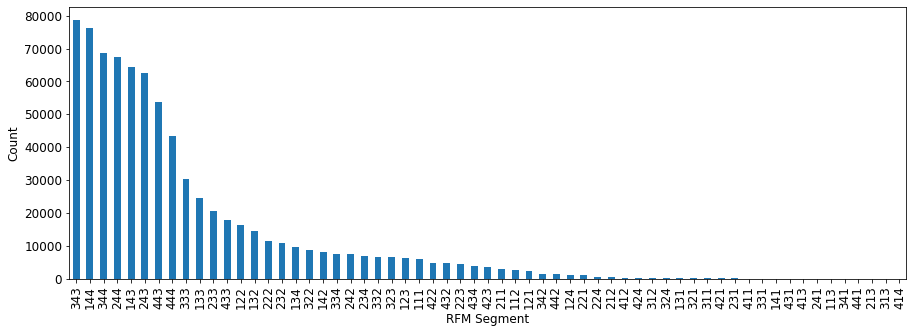

In [38]:
ax = rfm_jenks['RFM_Segment'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Segment", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [39]:
rfm_jenks['RFM_Score'] = rfm_jenks[['J_Rscore','J_Fscore','J_Mscore']].sum(axis=1)
rfm_jenks.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,recency,frequency,monetary,J_Rscore,J_Fscore,J_Mscore,RFM_Segment,RFM_Score
0,0002YJ,395,1,298.32,2,4,3,243,9
1,000986,483,1,155.22,3,4,4,344,11
2,000CMS,536,1,166.32,3,4,4,344,11
3,000H95,628,1,57.60,3,4,4,344,11
4,000IS0,723,2,358.20,4,3,3,433,10


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'RFM Score')

Text(0, 0.5, 'Count')

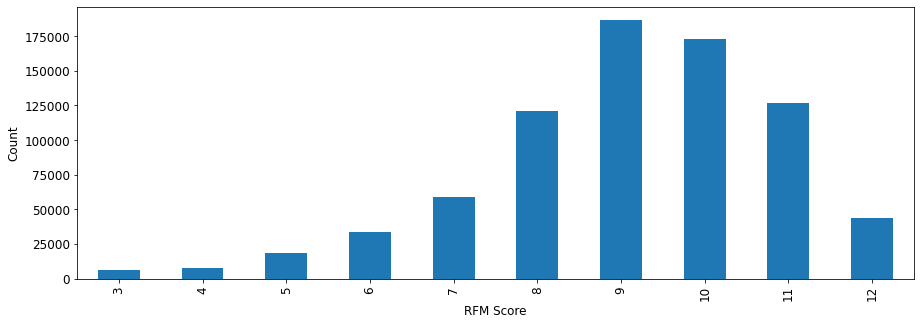

In [40]:
ax = rfm_jenks['RFM_Score'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

#### K-means clustering with Jenks NB 

In [41]:
rfm_jenks_scaled = RFM.copy()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1152x1008 with 0 Axes>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='frequency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monetary', ylabel='Density'>

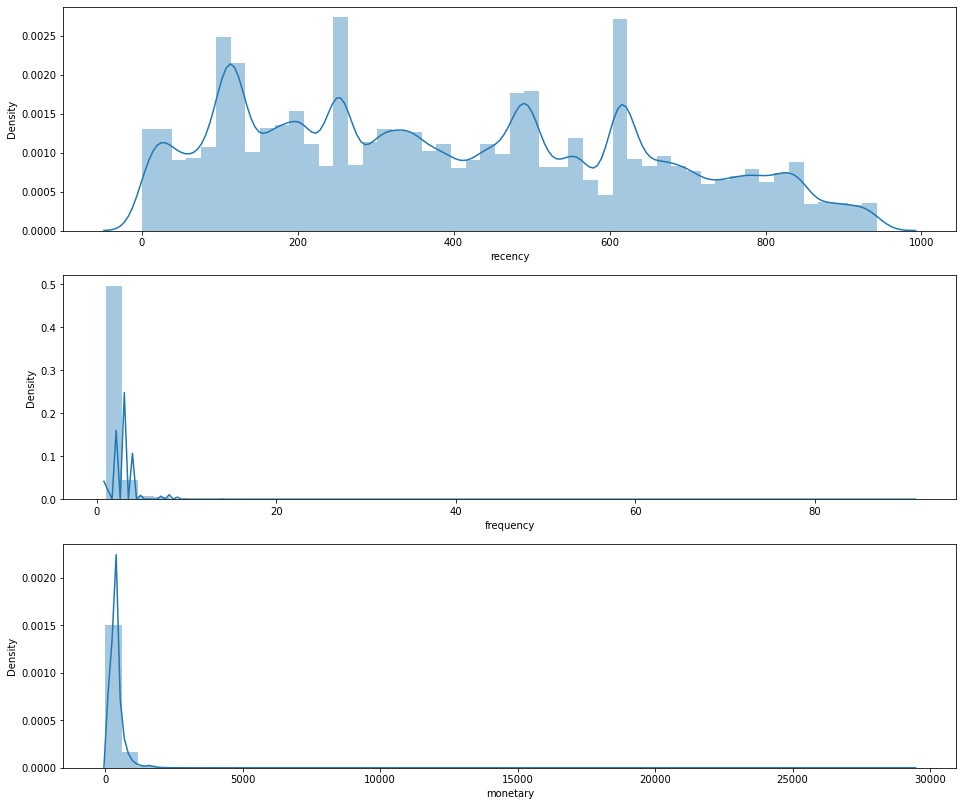

In [42]:
#check current skewness
plt.figure(figsize=(16,14))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_jenks_scaled['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_jenks_scaled['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_jenks_scaled['monetary'])

# Show the plot
plt.show()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1152x1008 with 0 Axes>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='frequency', ylabel='Density'>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monetary', ylabel='Density'>

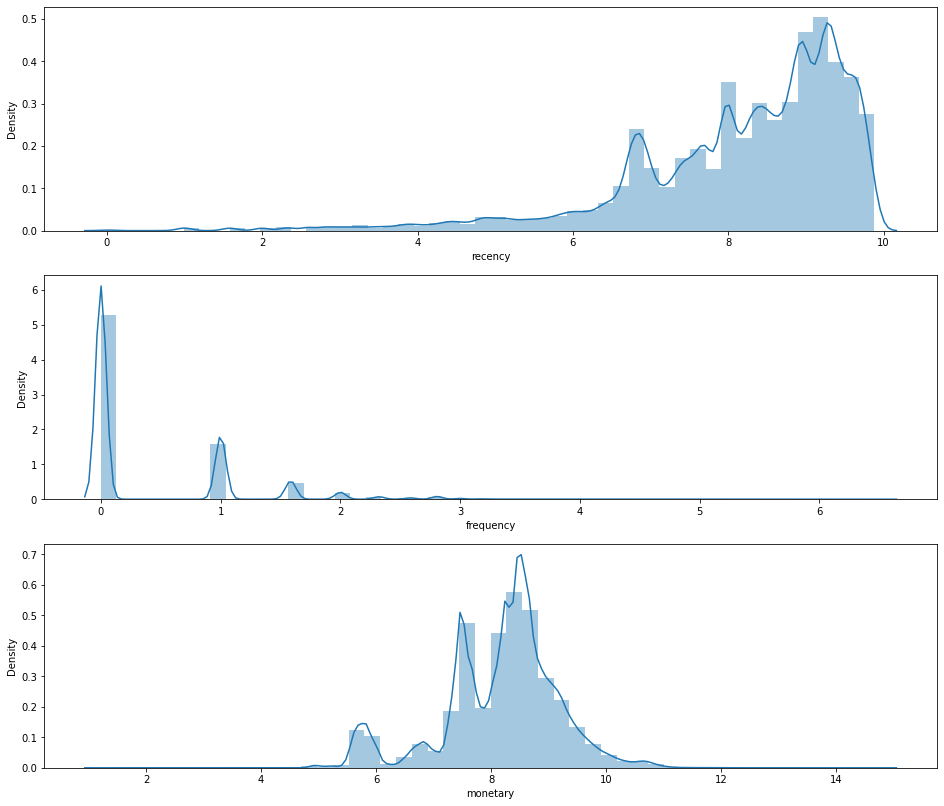

In [43]:
#normalisation 
#https://towardsdatascience.com/rfmt-segmentation-using-k-means-clustering-76bc5040ead5

# Apply Log Transformation
rfm_jenks_scaled['monetary'] = rfm_jenks_scaled['monetary'] + 0.0000000001
recency_log = np.log2(rfm_jenks_scaled['recency'])
frequency_log = np.log2(rfm_jenks_scaled['frequency'])
monetary_log = np.log2(rfm_jenks_scaled['monetary'])

# Plot RFM distributions
plt.figure(figsize=(16,14))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(recency_log)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(frequency_log)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(monetary_log)

# Show the plot
plt.show()

In [44]:
#scaling
#https://towardsdatascience.com/rfmt-segmentation-using-k-means-clustering-76bc5040ead5
data_for_clustering_scaled = rfm_jenks_scaled.iloc[:, 1:4]
scaler = StandardScaler()
scaler.fit(data_for_clustering_scaled)
data_for_clustering_scaled = scaler.transform(data_for_clustering_scaled)

data_for_clustering_scaled = pd.DataFrame(data_for_clustering_scaled, columns=["recency","frequency","monetary"])
data_for_clustering_scaled.head(10)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


StandardScaler()

,recency,frequency,monetary
0,-0.007754,-0.482135,-0.236470
1,0.347060,-0.482135,-0.783040
2,0.560755,-0.482135,-0.740644
3,0.931697,-0.482135,-1.155899
4,1.314735,0.425850,-0.007759
5,0.121269,-0.482135,-0.566704
6,-1.572162,-0.482135,-0.290211
7,0.387380,0.425850,0.219119
8,-1.560066,-0.482135,-0.859697
9,0.665587,-0.482135,-0.007759


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeans(n_clusters=1, random_state=1)

KMeans(n_clusters=2, random_state=1)

KMeans(n_clusters=3, random_state=1)

KMeans(n_clusters=4, random_state=1)

KMeans(n_clusters=5, random_state=1)

KMeans(n_clusters=6, random_state=1)

KMeans(n_clusters=7, random_state=1)

KMeans(random_state=1)

KMeans(n_clusters=9, random_state=1)

KMeans(n_clusters=10, random_state=1)

KMeans(n_clusters=11, random_state=1)

KMeans(n_clusters=12, random_state=1)

KMeans(n_clusters=13, random_state=1)

KMeans(n_clusters=14, random_state=1)

Text(0.5, 0, 'Number of clusters, k')

Text(0, 0.5, 'Inertia')

([<matplotlib.axis.XTick at 0x7f2c23fd2f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

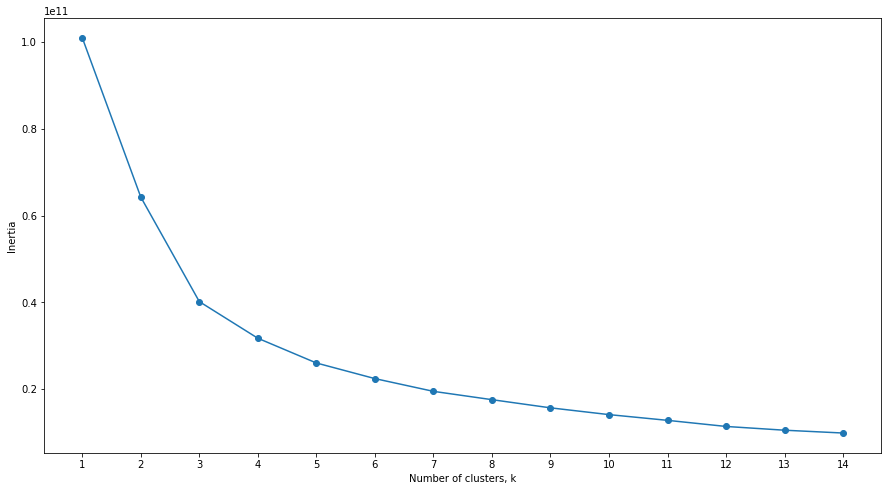

In [45]:
from sklearn.cluster import KMeans
#First : Get the Best KMeans 
ks = range(1,15)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_jenks_scaled.iloc[:, 1:4])
    inertias.append(kc.inertia_)
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.show()
plt.savefig("number of clusters.png", )

In [46]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
data_for_clustering = rfm_jenks_scaled.iloc[:, 1:4]
scaled_data = np.asarray(data_for_clustering_scaled).astype(float)

# choose k range
k_range=range(1,20)
# compute adjusted intertia
best_k, results = chooseBestKforKMeans(scaled_data, k_range)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Adjusted Inertia for each K')

Text(0.5, 0, 'K')

Text(0, 0.5, 'Adjusted Inertia')

([<matplotlib.axis.XTick at 0x7f2c22eaa280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

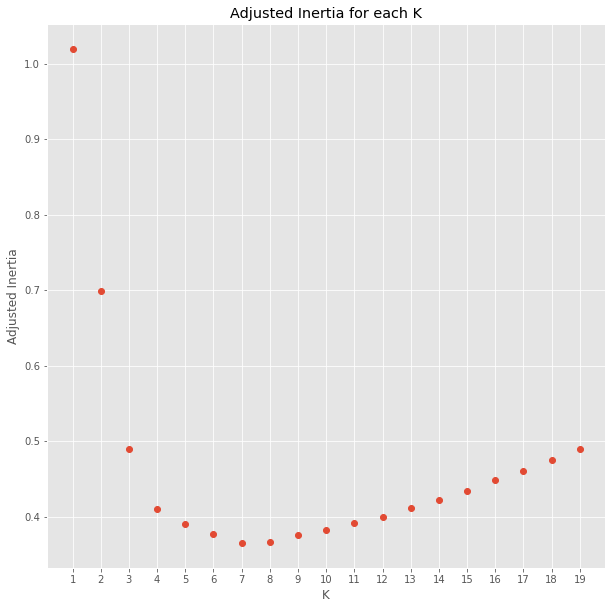

In [48]:
# plot the results
plt.figure(figsize=(10,10))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(1,20,1))

In [49]:
kc = KMeans(n_clusters= 7, random_state=88)

kc.fit(data_for_clustering_scaled)

#Create a cluster label column in the original DataFrame

cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:

rfm_k7 = data_for_clustering_scaled.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:

rfm_k7.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean', 'count'],}).round(4)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeans(n_clusters=7, random_state=88)

recency frequency monetary        
             mean      mean     mean   count
K_Cluster                                   
0         -0.9911   -0.3919  -0.5851  180873
1         -0.8472    0.1214   0.5714  118428
2          1.3322   -0.4500  -0.3447  156074
3          0.9217    0.6678   0.3867   84108
4         -0.8725    5.1372   4.3899   13025
5         -0.5749    1.9342   1.7199   41903
6          0.1626   -0.4249  -0.3834  182107

In [50]:
rfm_norm = data_for_clustering_scaled

rfm_norm = pd.DataFrame(rfm_norm,index=rfm_jenks.index,columns=rfm_jenks.columns)

rfm_norm["customer_id"] = rfm_jenks_scaled['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

#rfm_norm['General_Segment'] = segmented_rfm['General_Segment']

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric',value_name='Value')


rfm_melt.head()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,K_Cluster,Metric,Value
0,0002YJ,6,recency,-0.007754
1,000986,6,recency,0.347060
2,000CMS,6,recency,0.560755
3,000H95,2,recency,0.931697
4,000IS0,3,recency,1.314735


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

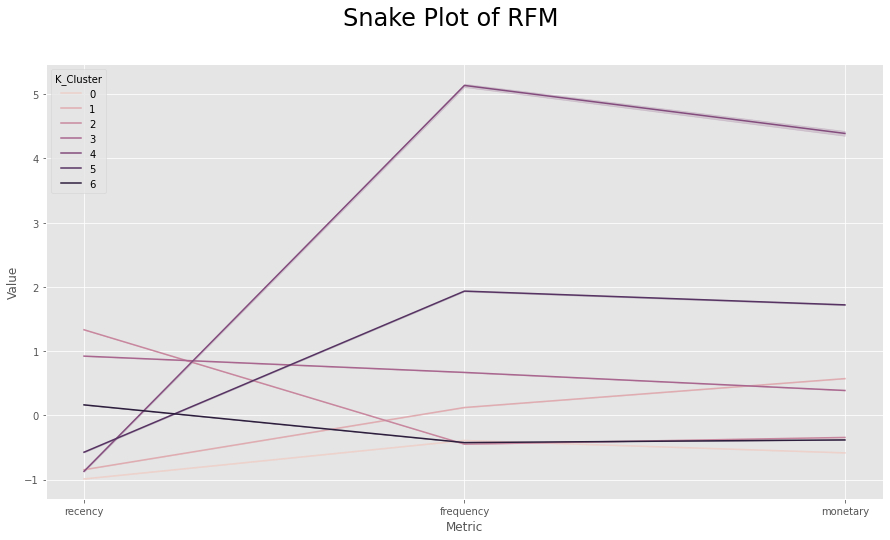

In [52]:
#f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

#sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt)

plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

In [53]:
## Save cluster into csv
#rfm_melt.head()
#rfm_melt.to_csv("rfm_k7.csv", index=False)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,K_Cluster,Metric,Value
0,0002YJ,6,recency,-0.007754
1,000986,6,recency,0.347060
2,000CMS,6,recency,0.560755
3,000H95,2,recency,0.931697
4,000IS0,3,recency,1.314735


#### 2.2 jenks break with log2

In [52]:
rfmlog2 = RFM.copy()
rfmlog2.head()

,customer_id,recency,frequency,monetary
0,0002YJ,395,1,298.32
1,000986,483,1,155.22
2,000CMS,536,1,166.32
3,000H95,628,1,57.60
4,000IS0,723,2,358.20


In [53]:
rfmlog2.recency.max()

943

In [54]:
rfmlog2["recency_log2"] = np.log2(rfmlog2["recency"])
rfmlog2["frequency_log2"] = np.log2(rfmlog2["frequency"])
rfmlog2["monetary_log2"] = np.log2(rfmlog2["monetary"])
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717
1,000986,483,1,155.22,8.915879,0.0,7.278171
2,000CMS,536,1,166.32,9.066089,0.0,7.377818
3,000H95,628,1,57.60,9.294621,0.0,5.847997
4,000IS0,723,2,358.20,9.497852,1.0,8.484622


In [55]:
rfmlog2.recency_log2.min()

0.0

In [56]:
logr_breaks = jenkspy.jenks_breaks(rfmlog2['recency_log2'], nb_class=4)
logf_breaks = jenkspy.jenks_breaks(rfmlog2['frequency_log2'], nb_class=4)
logm_breaks = jenkspy.jenks_breaks(rfmlog2['monetary_log2'], nb_class=4)

In [57]:
log_jenks_spread = pd.DataFrame(list(zip(logr_breaks, logf_breaks, logm_breaks)), 
                      columns=['log_J_Recency','log_J_Frequency', 'log_J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
log_jenks_spread

,log_J_Recency,log_J_Frequency,log_J_Monetary
min,0.000000,0.000000,1.137504
first_part,5.321928,0.000000,6.663629
second_part,7.375039,1.000000,7.974242
third_part,8.668885,2.000000,8.979282
max,9.881114,6.507795,14.844397


<Figure size 1152x432 with 0 Axes>

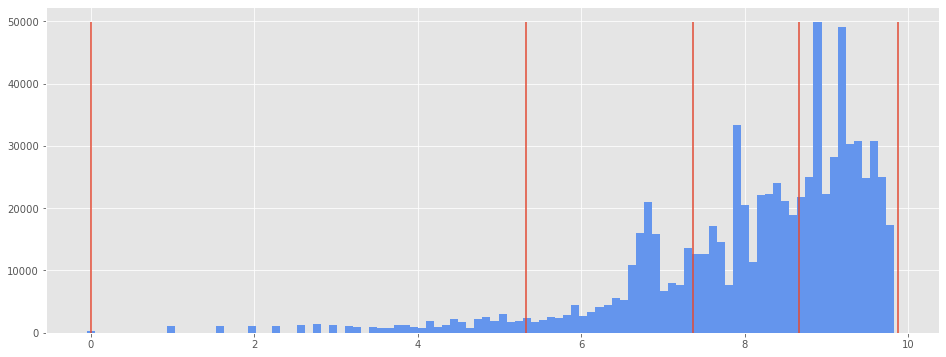

In [58]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfmlog2['recency_log2'], bins=100, align='left', color='cornflowerblue')
for b in logr_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

<Figure size 1152x432 with 0 Axes>

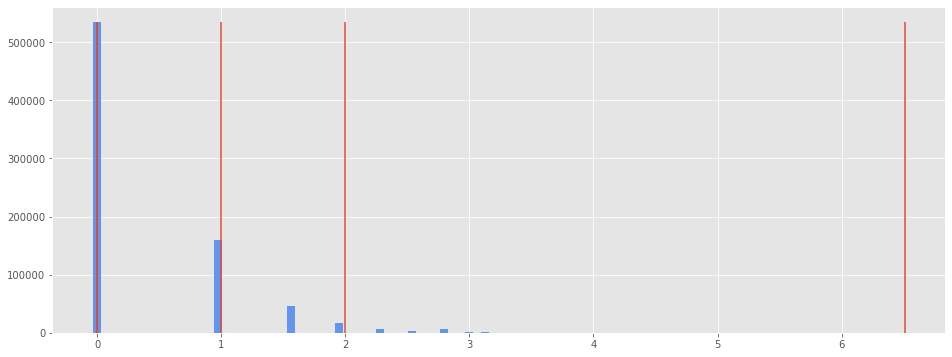

In [59]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfmlog2['frequency_log2'], bins=100, align='left', color='cornflowerblue')
for b in logf_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

<Figure size 1152x432 with 0 Axes>

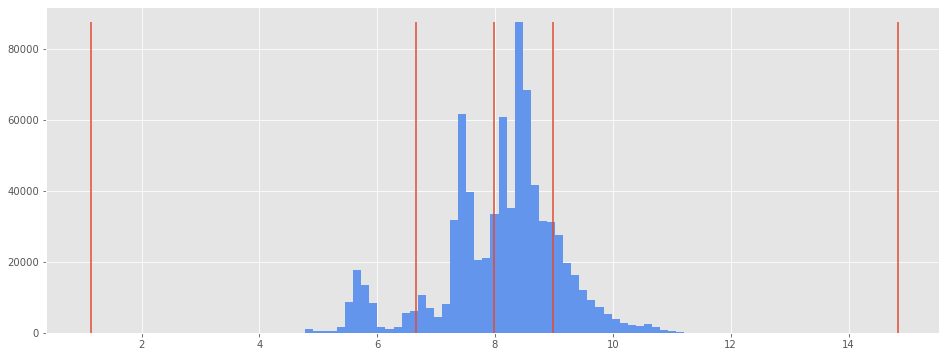

In [60]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfmlog2['monetary_log2'], bins=100, align='left', color='cornflowerblue')
for b in logm_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [61]:
log_jenks_spread

,log_J_Recency,log_J_Frequency,log_J_Monetary
min,0.000000,0.000000,1.137504
first_part,5.321928,0.000000,6.663629
second_part,7.375039,1.000000,7.974242
third_part,8.668885,2.000000,8.979282
max,9.881114,6.507795,14.844397


In [62]:
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717
1,000986,483,1,155.22,8.915879,0.0,7.278171
2,000CMS,536,1,166.32,9.066089,0.0,7.377818
3,000H95,628,1,57.60,9.294621,0.0,5.847997
4,000IS0,723,2,358.20,9.497852,1.0,8.484622


why log2 is used:
- interpretability
- Log2 aids in calculating fold change, by which measure the up-regulated vs down-regulated genes between samples.
Usually, Log2 measured data more close to the biologically-detectable changes.

### 2.2.1 Jenks Assignment, RFM Score & Evaluation

In [63]:
#Assign Jenks
def JenksScoreR(x):
    for i in range(0,4):
        if log_jenks_spread.log_J_Recency[i] <= x <= log_jenks_spread.log_J_Recency[i+1]:
            return (i+1)
        
def JenksScoreF(x):
    for i in range(0,4):
        if log_jenks_spread.log_J_Frequency[i] <= x <= log_jenks_spread.log_J_Frequency[i+1]:
            return (4-i)
        
def JenksScoreM(x):
    for i in range(0,4):
        if log_jenks_spread.log_J_Monetary[i] <= x <= log_jenks_spread.log_J_Monetary[i+1]:
            return (4-i)

In [64]:
rfmlog2["J_Rscore"] = rfmlog2["recency_log2"].apply(JenksScoreR)
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2,J_Rscore
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717,3
1,000986,483,1,155.22,8.915879,0.0,7.278171,4
2,000CMS,536,1,166.32,9.066089,0.0,7.377818,4
3,000H95,628,1,57.60,9.294621,0.0,5.847997,4
4,000IS0,723,2,358.20,9.497852,1.0,8.484622,4


In [65]:
rfmlog2["J_Fscore"] = rfmlog2["frequency_log2"].apply(JenksScoreF)
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2,J_Rscore,J_Fscore
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717,3,4
1,000986,483,1,155.22,8.915879,0.0,7.278171,4,4
2,000CMS,536,1,166.32,9.066089,0.0,7.377818,4,4
3,000H95,628,1,57.60,9.294621,0.0,5.847997,4,4
4,000IS0,723,2,358.20,9.497852,1.0,8.484622,4,3


In [66]:
rfmlog2["J_Mscore"] = rfmlog2["monetary_log2"].apply(JenksScoreM)
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2,J_Rscore,J_Fscore,J_Mscore
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717,3,4,2
1,000986,483,1,155.22,8.915879,0.0,7.278171,4,4,3
2,000CMS,536,1,166.32,9.066089,0.0,7.377818,4,4,3
3,000H95,628,1,57.60,9.294621,0.0,5.847997,4,4,4
4,000IS0,723,2,358.20,9.497852,1.0,8.484622,4,3,2


In [67]:
rfmlog2['RFM_Segment'] = rfmlog2.J_Rscore.map(str)+rfmlog2.J_Fscore.map(str)+rfmlog2.J_Mscore.map(str)
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2,J_Rscore,J_Fscore,J_Mscore,RFM_Segment
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717,3,4,2,342
1,000986,483,1,155.22,8.915879,0.0,7.278171,4,4,3,443
2,000CMS,536,1,166.32,9.066089,0.0,7.377818,4,4,3,443
3,000H95,628,1,57.60,9.294621,0.0,5.847997,4,4,4,444
4,000IS0,723,2,358.20,9.497852,1.0,8.484622,4,3,2,432


Text(0.5, 0, 'RFM Segment')

Text(0, 0.5, 'Count')

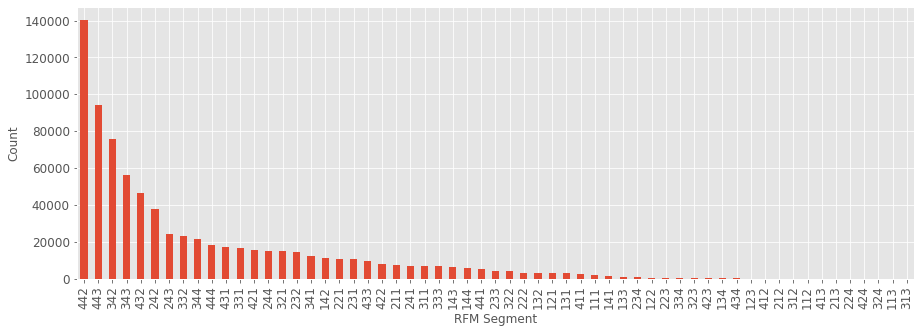

In [68]:
ax = rfmlog2['RFM_Segment'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Segment", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

There are evidently more RFM segment compared to the quantile-based method elaborated in 2.0. This is due to the presence of frequency jenks score of 3 as opposed to the absence of frequency quartile 3 under the quartile-method 

In [69]:
rfmlog2['RFM_Score'] = rfmlog2[['J_Rscore','J_Fscore','J_Mscore']].sum(axis=1)
rfmlog2.head()

,customer_id,recency,frequency,monetary,recency_log2,frequency_log2,monetary_log2,J_Rscore,J_Fscore,J_Mscore,RFM_Segment,RFM_Score
0,0002YJ,395,1,298.32,8.625709,0.0,8.220717,3,4,2,342,9
1,000986,483,1,155.22,8.915879,0.0,7.278171,4,4,3,443,11
2,000CMS,536,1,166.32,9.066089,0.0,7.377818,4,4,3,443,11
3,000H95,628,1,57.60,9.294621,0.0,5.847997,4,4,4,444,12
4,000IS0,723,2,358.20,9.497852,1.0,8.484622,4,3,2,432,9


Text(0.5, 0, 'RFM Score')

Text(0, 0.5, 'Count')

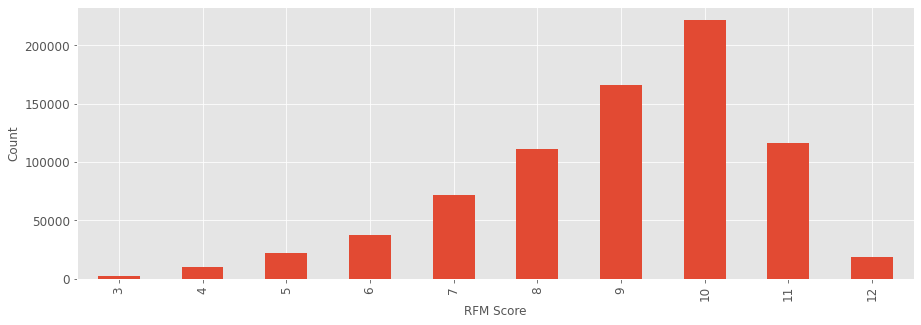

In [70]:
ax = rfmlog2['RFM_Score'].value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

The sequence in which the RFM score is presented in as ordered by descending count is similar in both quartile-based and Jenks Natural Break based methods, with exception to RFM score of 8 and 11. In the quartile-based method RFM score 8 has the 3rd most count, while RFM score 11 has the 4th most count. Whereas in the Jenks Natural Break method, it is the opposite. 

The distribution of the RFM score is also much steeper under the Jenks Natural Break method.

## Data Pre-processing for the K-means

Distribution check 
Rounding of infinite floats

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency_log2's: Skew: -1.6206671207142385, : SkewtestResult(statistic=-422.06241403665246, pvalue=0.0)


<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


frequency_log2's: Skew: 1.5826180802299763, : SkewtestResult(statistic=415.8453130896836, pvalue=0.0)


<AxesSubplot:>

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


monetary_log2's: Skew: -0.6070370972316118, : SkewtestResult(statistic=-202.06545295924187, pvalue=0.0)


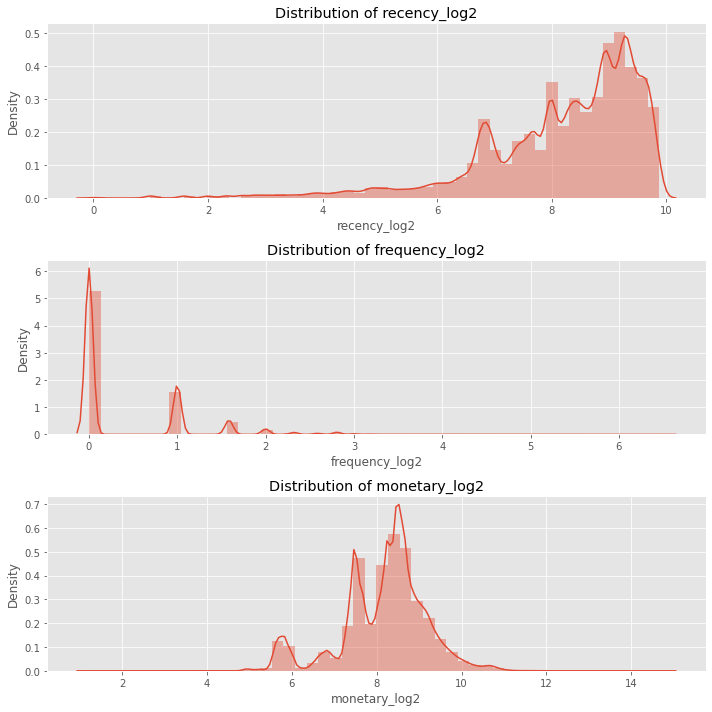

In [71]:
# Creating a function to check the distribution of R, F and M and assess skewness level
def check_distribution(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
check_distribution(rfmlog2,'recency_log2')

plt.subplot(3, 1, 2)
check_distribution(rfmlog2,'frequency_log2')

plt.subplot(3, 1, 3)
check_distribution(rfmlog2,'monetary_log2')

plt.tight_layout()


In [72]:
rfmlog2.iloc[:, 4:7] = round(rfmlog2.iloc[:, 4:7],5)

### Inertia

KMeans(n_clusters=1, random_state=1)

KMeans(n_clusters=2, random_state=1)

KMeans(n_clusters=3, random_state=1)

KMeans(n_clusters=4, random_state=1)

KMeans(n_clusters=5, random_state=1)

KMeans(n_clusters=6, random_state=1)

KMeans(n_clusters=7, random_state=1)

KMeans(random_state=1)

KMeans(n_clusters=9, random_state=1)

KMeans(n_clusters=10, random_state=1)

KMeans(n_clusters=11, random_state=1)

KMeans(n_clusters=12, random_state=1)

KMeans(n_clusters=13, random_state=1)

KMeans(n_clusters=14, random_state=1)

Text(0.5, 0, 'Number of clusters, k')

Text(0, 0.5, 'Inertia')

([<matplotlib.axis.XTick at 0x7f328a52f160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

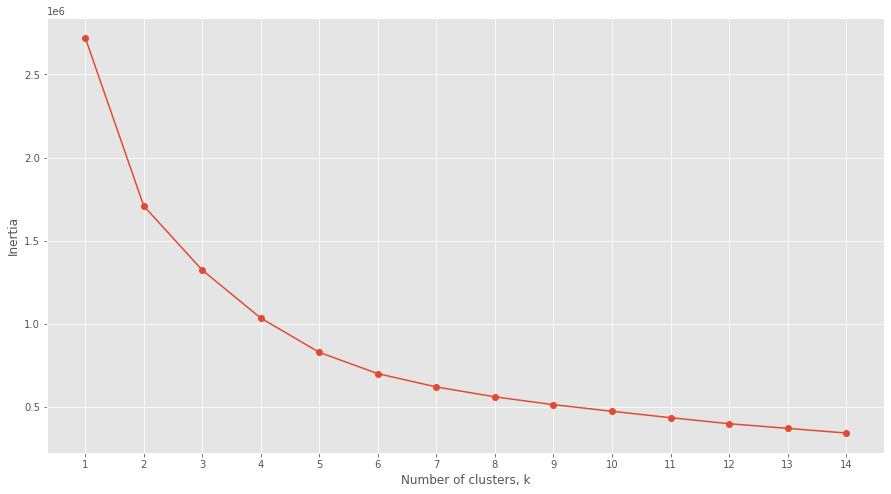

In [73]:
from sklearn.cluster import KMeans
#First : Get the Best KMeans 
ks = range(1,15)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfmlog2.iloc[:, 4:7])
    inertias.append(kc.inertia_)
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.show()

### Scaled Inertia

In [74]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

In [75]:
data_for_clustering = rfmlog2.iloc[:, 4:7]
scaled_data = np.asarray(data_for_clustering).astype(float)

# choose k range
k_range=range(1,20)
# compute adjusted intertia
best_k, results = chooseBestKforKMeans(scaled_data, k_range)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Adjusted Inertia for each K')

Text(0.5, 0, 'K')

Text(0, 0.5, 'Adjusted Inertia')

([<matplotlib.axis.XTick at 0x7f328a52b280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

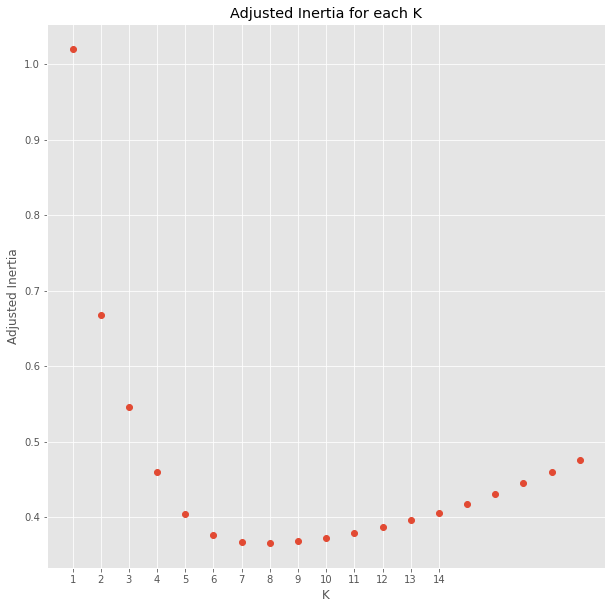

In [76]:
# plot the results
plt.figure(figsize=(10,10))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(1,15,1))

### K-means clustering with Jenks Break Log

In [77]:
data_for_clustering.head()

,recency_log2,frequency_log2,monetary_log2
0,8.62571,0.0,8.22072
1,8.91588,0.0,7.27817
2,9.06609,0.0,7.37782
3,9.29462,0.0,5.84800
4,9.49785,1.0,8.48462


In [78]:
kc = KMeans(n_clusters= 8, random_state=88)

kc.fit(data_for_clustering)

#Create a cluster label column in the original DataFrame

cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:

rfm_k8 = data_for_clustering.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:

rfm_k8.groupby('K_Cluster').agg({'recency_log2': 'mean','frequency_log2': 'mean','monetary_log2': ['mean', 'count'],}).round(0)

KMeans(random_state=88)

recency_log2 frequency_log2 monetary_log2        
                  mean           mean          mean   count
K_Cluster                                                  
0                  9.0            0.0           7.0  138956
1                  8.0            0.0           8.0  131147
2                  4.0            0.0           8.0   34185
3                  9.0            0.0           8.0  156832
4                  9.0            1.0           9.0  123576
5                  8.0            0.0           6.0   53485
6                  7.0            0.0           8.0   83860
7                  7.0            2.0          10.0   54477

In [79]:
#rfm_k8.rename(columns={"recency_log2":"recency","frequency_log2":"frequency","monetary_log2":"monetary"})

In [80]:
rfm_norm = data_for_clustering

rfm_norm = pd.DataFrame(rfm_norm,index=rfmlog2.index,columns=rfmlog2.columns)

rfm_norm["customer_id"] = rfmlog2['customer_id']

rfm_norm['K_Cluster'] = kc.labels_

#rfm_norm['General_Segment'] = segmented_rfm['General_Segment']

rfm_norm.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt = pd.melt(rfm_norm,id_vars=['customer_id','K_Cluster'],
                   value_vars=['recency_log2', 'frequency_log2', 'monetary_log2'],
                   var_name='Metric',value_name='Value')


rfm_melt.head()

,customer_id,K_Cluster,Metric,Value
0,0002YJ,3,recency_log2,8.62571
1,000986,0,recency_log2,8.91588
2,000CMS,0,recency_log2,9.06609
3,000H95,0,recency_log2,9.29462
4,000IS0,4,recency_log2,9.49785


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Metric', ylabel='Value'>

Text(0.5, 0.98, 'Snake Plot of RFM')

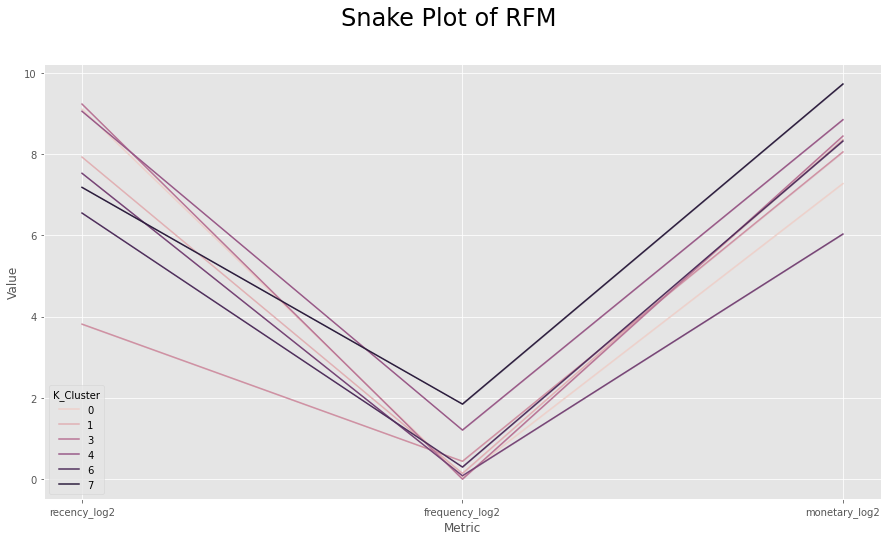

In [81]:
#f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

#sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
plt.figure(figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt)

plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()